<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Natural Language Processing - Classifying Definitions of Nouns and Adjectives

---
## Part 2: Exploratory Data Analysis (EDA)
---

## Contents
---
- [Overview](##Overview)
- [Maximising Performance](##Maximising-Performance)
- [Exploratory Data Analysis](##Exploratory-Data-Analysis)

---
## Overview
---

Now that we have the definitions, the next time would be to conduct EDA to get an idea of what we’re dealing with. There will be three key components - length of definitions, part-of-speech combinations found in definitions, as well as patterns that may be found across the definitions themselves.

---
## Maximising Performance
---

### `spaCy`

`spaCy` has the functionality to tokenise text and label the resulting tokens with their corresponding parts-of-speech (POS), also known as word classes. Here is an example sentence and how spaCy may label it:

| Word | POS | Full POS |
| --- | --- | --- |
| I | PRON | pronoun |
| left | VERB | verb |
| my | DET | determiner |
| bag | NOUN | noun |
| on | ADP | adposition |
| the | DET | determiner |
| counter | NOUN | noun |
| . | PUNCT | punctuation |

Since the dataset consists of _formal_ definitions that use standard English, the labelling of POS is likely to be very accurate (as opposed to labelling forum posts with misspelt words, for example). 

Here’s an overview of POS in spaCy:
| POS (Abbreviated) | POS (Full) |
| --- | --- |
| ADJ | adjective |
| ADP | adposition |
| ADV | adverb |
| AUX | auxiliary verb |
| CONJ | coordinating conjunction |
| CCONJ | coordinating conjunction |
| DET | determiner |
| INTJ | interjection |
| NOUN | noun |
| NUM | numeral |
| PART | particle |
| PRON | pronoun |
| PROPN | proper noun |
| PUNCT | punctuation |
| SCONJ | subordinating conjunction |
| SYM | symbol |
| VERB | verb |
| X | other |

The reasoning behind including POS will be given during the EDA portion.


### CountVectorizer

During the vectorisation process, text will be split into tokens and converted into lowercase. The `stop_words` function, while often used, will not be used in this case as there may be important phrases that will be missed out on if it’s used. The likelihood that such phrases exist is higher than usual, given that these are formal definitions. In addition, to be able to properly utilise POS, all of the words should preferably be left in.

The other popular choice of vectoriser, TfidfVectorizer, will not be used here. The key difference between the two is as such: Tfidf prioritises the importance of a word to a specific observation while CountVec simply counts its occurrences. The former is often useful in informal texts or lengthy documents. 

However, in this case, definitions are short and unlikely to contain repetitive words and phrases _within_ the definitions themselves. Instead, we have to rely on phrases that are used consistently across observations for a specific word class. The issue here is that Tfidf will penalise such features, even though they are in fact quite important. Based on this line of reasoning, we will utilise CountVec for the EDA. Whether or not the above reasoning holds water will be tested at the modelling stage.

That said, while the above may be true sometimes, it is not necessarily always true, which is something we will see at the modelling stage. However, at the EDA stage, it is sufficient to use just one of them to conduct an analysis, because the specific advantage of Tfidf that I was referring to (and will not bring up at this juncture) will not have an impact on the EDA process.

In [1]:
import numpy as np
import pandas as pd

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Function to process data with spaCy, specifically to tag words to their respective parts-of-speech (POS).

def process_with_spacy(string):
    
    '''   
    Parameters
    ----------
    string : str
        Text (str) to be processed.
    '''
    
    word_definition = nlp(string)
    
    # Extract tokenised data.
    tokens = [token.text for token in word_definition]
    
    # Extract POS for each token.
    pos = [word_class.pos_ for word_class in word_definition]
    
    # Create DataFrame to store the above information.
    df = pd.DataFrame([
        {'tokens': tokens, 
         'pos': pos}
    ])
    
    return df

In [3]:
# Function to vectorise data using CountVectorizer and return a sparse matrix containing...
# the vectorised features (columns) and their respective values.

def vectorise(df=None,
              col=None,
              ngram_range=(1,4),
              min_df=1, 
              max_df=1.0,
              max_features=1000):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    col : str
        Column of DataFrame to extract data to vectorise from.
    ngram_range : tuple
        Minimum and maximum ngrams to use during the vectorisation process.    
    min_df : int, float
        Minimum number (int) or percentage (float) of occurences, 
        across observations, needed for word (feature) to be included.
    max_df : int, float
        Upper limit (number, if int; percentage, if float) of occurences, 
        across observations, beyond which a word (feature) will not be included.
    max_features : int
        Maximum number of features to include in model.
    '''
    
    X = df[col]
    y = df['word_class']

    vec = CountVectorizer(min_df=min_df, 
                          max_df=max_df,
                          ngram_range=ngram_range, 
                          max_features=max_features)

    vec.fit(X)

    X = vec.transform(X)
    
    # Create a DataFrame that has the vectorised features as its columns...
    # observations as its rows and values that reflect frequency counts.
    X_df = pd.DataFrame(X.todense(),
                        columns=vec.get_feature_names_out())

    # Same as X_df, but with word class of each observation reflected.
    df_vectorised = pd.merge(pd.DataFrame(y).reset_index(),
                             X_df,
                             how='outer',
                             left_index=True,
                             right_index=True)
    
    return df_vectorised.drop('index', axis=1)

In [4]:
def analyse_with_spacy(df=None,
                       col=None,
                       ngram_range=(1,4), 
                       min_df=1,
                       max_df=1.0,
                       to_filter=False,
                       filter_min=None,
                       filter_max=None):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    col : str
        Column of DataFrame to extract data to vectorise from.
    ngram_range : tuple
        Minimum and maximum ngrams to use during the vectorisation process.    
    min_df : int, float
        Minimum number (int) or percentage (float) of occurences, 
        across observations, needed for word (feature) to be included.
    max_df : int, float
        Upper limit (number, if int; percentage, if float) of occurences, 
        across observations, beyond which a word (feature) will not be included.
    to_filter : bool
        If True, count_dict will be filtered.
    filter_min : float
        Will be used if to_filter is set to `True`.
    filter_max : float
        Will be used if to_filter is set to `True`.
    '''
    
    unique_values = [val for val in set([val for lst in df[col].values for val in lst])]
    
    # Create a filtered version of the DataFrame that only includes 'word_class' as well as the specified columns.
    df_filtered = df[['word_class', col, f'{col}_str']]
    
    # Apply vectorisation.
    df_vectorised = vectorise(df=df_filtered,
                              col=f'{col}_str',
                              ngram_range=ngram_range,
                              min_df=min_df,
                              max_df=max_df)
    
    # For each feature, count frequency by class and include information in a dictionary.
    count_dict = {key:
                  [df_vectorised[df_vectorised.word_class == 0][key].sum(),
                   df_vectorised[df_vectorised.word_class == 1][key].sum()] \
                  for key in df_vectorised.columns}
    
    # Delete irrelevant information.
    del count_dict['word_class']
    
    # Include a third value for the dictionary.
    # This value represents the proportion of nouns out of the combined occurrences (nouns + adjectives).
    count_dict = {key: [val[0], val[1], np.round(val[0]/(val[0]+val[1]), 5)] for key, val in count_dict.items()}
    
    # Sort dictionary by third value (proportion).
    count_dict = dict(sorted(count_dict.items(), key=lambda x: x[1][2]))
    
    # Filter dictionary by the relevant parameters if `to_filter` is set to True.
    if to_filter:
        
        count_dict = {key: val for key, val in count_dict.items() if (val[2] >= filter_max) or (val[2] <= filter_min)}
    
    return {
        'df': df_vectorised,
        'dict': count_dict
    }

In [5]:
# Function to create bar charts specifically for POS.

def bar_pos(dictionary=None, 
            colour_range=None):
    
    '''   
    Parameters
    ----------
    dictionary : dict
        Dictionary to obtain information from.
    colour_range : list of int
        Used like an indexer for colouring of bars. 
    '''
    
    # Extracts only the relevant value from the input dictionary, specifically, proportion.
    new_dict = {key: val[2] for key, val in dictionary.items()}
    
    # Set figure size for bar chart.
    fig, ax = plt.subplots(figsize=(16,6))
    
    # Create a bar chart using the dictionary's keys as the x-axis labels and...
    # the dictionary's values as the values to be plotted.
    ax.bar(list(new_dict.keys()), 
           list(new_dict.values()), 
           color=['deepskyblue' for i in range(colour_range[0])]+['coral' for i in range(colour_range[1])])
    
    # Set the x-axis labels to appear a certain way.
    ax.set_xticklabels(list(new_dict.keys()), 
                       rotation=45, 
                       ha='right')

    plt.xlabel('Parts of Speech')
    plt.ylabel('Proportion (nouns out of total)')
    plt.title('Parts of Speech')
    
    plt.show();

In [6]:
# Function to create bar charts specifically for post-vectorisation features.

def bar_features(df=None, 
                 title=None):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    title : str
        Title for bar chart.
    '''
    
    plt.figure(figsize=(10,8))

    df.sum(axis=0).sort_values(ascending=False).head(30).plot(kind='barh')
    
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Features')
    plt.title(f'Important Features ({title})')
    
    plt.show();

In [7]:
# Function to generate a word cloud based on input text.

def get_wordcloud(text):
    
    '''   
    Parameters
    ----------
    text : str
        Data to generate the word cloud from.
    '''

    # Generate word cloud using the specified parameters.
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color="white",
                          max_words=200, 
                          colormap='tab10', 
                          random_state=42).generate(text)

    # Display the word cloud.
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show();

In [8]:
# Function that takes in a dictionary and creates a DataFrame based on a set of criteria.

def filter_df(dictionary=None, 
              start=0, 
              stop=-1, 
              sort_by='count_noun', 
              ascending=False):
    
    '''   
    Parameters
    ----------
    dictionary : dict
        Dictionary to obtain information from.
    start : int
        Starting index to filter dictionary by.
    stop : int
        Ending index to filter dictionary by.
    sort_by : str
        Specifies which column to sort DataFrame by.
    ascending : bool
        Specifies whether or not to sort in ascending or descending order.
    '''
    
    df = pd.DataFrame.from_dict({key: dictionary[key] for key in list(dictionary.keys())[start:stop]}, 
                                orient='index', 
                                columns=['count_noun', 
                                         'count_adj', 
                                         'proportion']).sort_values(sort_by, ascending=ascending)
    
    return df

In [9]:
# Function that returns definitions from the specified DataFrame based on a certain set of conditions.

def show_definitions(df=None, 
                     col=None, 
                     word_class=0, 
                     text=None, 
                     cond_1=False, 
                     cond_2=False, 
                     cond_3=False, 
                     cond_4=False):
    
    '''   
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be used in function.
    col : str
        Column of DataFrame to extract data from.
    word_class : int
        Accepts 0 (noun) or 1 (adjective).
    text : str
        Text to filter the DataFrame by.
    cond_1 : bool
        If True, will be the chosen filter condition.
    cond_2 : bool
        If True, will be the chosen filter condition.
    cond_3 : bool
        If True, will be the chosen filter condition.
    cond_4 : bool
        If True, will be the chosen filter condition.
    '''
    
    # For all conditions, a common filter is that of word class.
    
    # For cond_1, return definitions that contain the specified text.
    if cond_1:
        cond_1 = (df[col].str.contains(text)) & (df['word_class'] == word_class)
        return df[cond_1]
    
    # For cond_2, return definitions that start with the specified text.
    elif cond_2:
        cond_2 = (df[col].str.startswith(text)) & (df['word_class'] == word_class)
        return df[cond_2]
    
    # For cond_3, return definitions that contain, but do not start with, the specified text.
    elif cond_3:
        cond_3 = (df[col].str.contains(text)) & (df[col].str.startswith(text) == False) & (df['word_class'] == word_class) 
        return df[cond_3]
    
    # For cond_4, return definitions that end with the specified text.
    elif cond_4:
        cond_4 = (df[col].str.endswith(text)) & (df['word_class'] == word_class)
        return df[cond_4]       

In [10]:
# Function that creates a combined histogram.

def grouped_hist(len_1=None, 
                 len_2=None, 
                 label_1=None, 
                 label_2=None, 
                 xlabel=None, 
                 ylabel=None, 
                 title=None):
    
    '''   
    Parameters
    ----------
    len_1 : list or int
        List of values to use in histogram.
    len_2 : list or int
        List of values to use in histogram.
    label_1 : str
        Legend label.
    label_2 : str
        Legend label.
    xlabel : str
        X-axis label.
    ylabel : str
        Y-axis label.
    title : str
        Title of chart.
    '''

    plt.figure(figsize=(12,6))

    # Create a histogram for each word class.
    n, bins, patches = plt.hist([len_1, len_2], 
                                bins=35, 
                                alpha=0.5, 
                                label=[label_1, label_2], 
                                color=['red', 'blue'], 
                                density=True)

    # Create a kernel density estimate.
    kde_1 = gaussian_kde(len_1)
    kde_2 = gaussian_kde(len_2)
    
    x_grid = np.linspace(0, df_words.length.max(), 100)
    
    # Visually represent the kde.
    plt.plot(x_grid, kde_1(x_grid), color='red')
    plt.plot(x_grid, kde_2(x_grid), color='blue')

    # Add title and labels.
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    # Show plot
    plt.show();

In [11]:
# Read in scraped data.

df_words = pd.read_csv('../data/nouns_and_adjectives.csv')

In [12]:
# Drop the unnecessary column.

df_words.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')

In [13]:
# Convert the dependent variable into binary classifications.
# 0 refers to nouns, 1 refers to adjectives.

df_words['word_class'] = np.where(df_words.word_class == 'noun', 0, 1)

In [14]:
# Check that classes are reasonably balanced.

df_words.word_class.value_counts(normalize=True)

0    0.515712
1    0.484288
Name: word_class, dtype: float64

In [15]:
# Load the English package from spaCy.

nlp = spacy.load('en_core_web_sm')

In [16]:
# Apply the process_with_spacy function to the dataset being used, specifically, word definitions.

df_processed = df_words.definition.apply(process_with_spacy)

In [17]:
# Include an additional column - POS - to the main DataFrame, df_words.

df_words = pd.concat([
    df_words, 
    pd.concat([df_processed[i] for i in range(df_processed.shape[0])]).reset_index().drop('index', axis=1)], 
    axis=1)

In [18]:
# Create an additional column that represents the POS as a str (rather than list of tokens).

df_words['pos_str'] = df_words.pos.map(lambda x: ' '.join(x).lower())

In [19]:
# Create an additional column that combines definitions and their POS.
# This will be the final data used to train the model.

df_words['definitions_and_pos'] = df_words.definition + df_words.pos_str

In [20]:
# Create an additional column that reflects the length of the definitions.

df_words['length'] = df_words.tokens.map(lambda x: len(x))

---
## Exploratory Data Analysis (EDA)
---

### Does length of definitions differ across word classes?

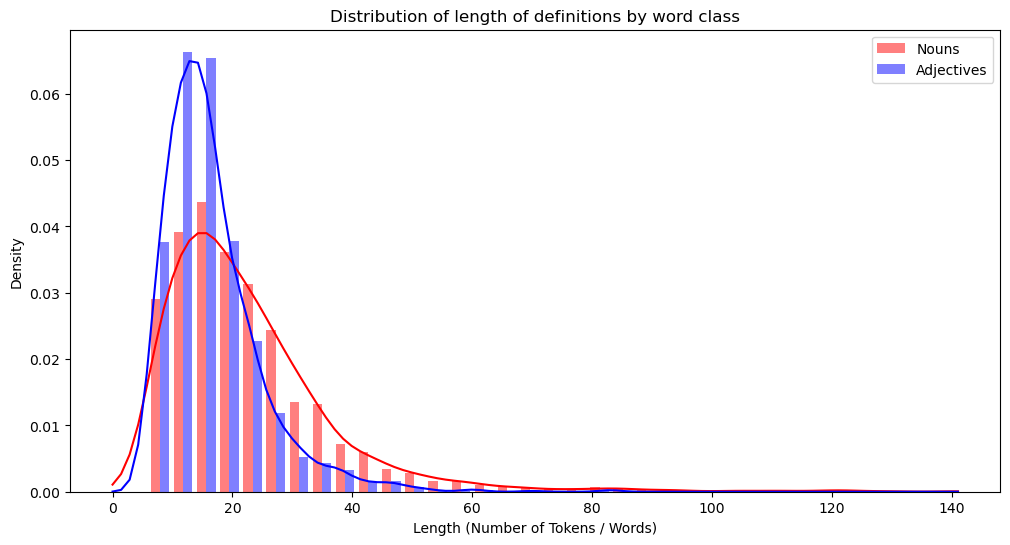

In [21]:
# Create a 'grouped' histogram to compare lengths of definitions by word class.

grouped_hist(len_1=df_words[df_words.word_class == 0]['length'], 
             len_2=df_words[df_words.word_class == 1]['length'],
             label_1='Nouns',
             label_2='Adjectives',
             xlabel='Length (Number of Tokens / Words)',
             ylabel='Density',
             title='Distribution of length of definitions by word class')

### Answer

The distributions of lengths of definitions for both nouns and adjectives are right-skewed. Specifically, few observations have lengths beyond 40. This is to be expected, given that while definitions can be quite verbose and explicit, they have to be kept as short and simple as possible to enhance understanding.

When contrasting the two classes, it can be seen that definitions of adjectives tend to be shorter than those of nouns. In addition, the graph is a lot gentler for nouns than for that of adjectives, because a significant proportion of the latter’s observations have lengths between 11 and 16, thus making the chart have a very prominent ‘peak’. 

This does have some implications, especially for adjectives. Firstly, it is possible that definitions of adjectives may be less informative. The following examples are from dictionary.com:
| Adjective | Definition |
| --- | --- |
| careless | not paying enough attention to what one does |
| careful | cautious in one's actions |

The definition for ‘careless’ is clearly more informative and descriptive of the actual word. The one for ‘careful’ is unfortunately quite carelessly done. Adjectives in particular are more prone to this because it is convenient to just define them in terms of the nouns they describe. 

The other potential issue pertains to structure. It is more difficult to find structural patterns when sentences are short. The idea of structure will be covered more under POS.

In [22]:
# Use the analyse_with_spacy function to generate key POS.

cvec_pos = analyse_with_spacy(df=df_words, 
                              col='pos', 
                              ngram_range=(2,5), 
                              min_df=0.1, 
                              max_df=0.5, 
                              to_filter=True, 
                              filter_min=0.3, 
                              filter_max=0.7)

In [23]:
# Use the vectorise() function to vectorise definitions.

df_vectorised = vectorise(df=df_words, 
                          col='definition', 
                          ngram_range=(1,4), 
                          min_df=0.01, 
                          max_df=0.3)

In [24]:
# Drop irrelevant stopwords.

df_vectorised = df_vectorised.drop(nltk.corpus.stopwords.words('english'), axis=1, errors='ignore')

In [25]:
# Separate df_vectorised into nouns...

df_vectorised_nouns = df_vectorised[df_vectorised.word_class == 0].drop('word_class', axis=1)

In [26]:
# ...and adjectives.

df_vectorised_adjs = df_vectorised[df_vectorised.word_class == 1].drop('word_class', axis=1)

In [27]:
# Create a list to store features that are common across both word classes.

distractors = [i for i in df_vectorised_nouns.sum(axis=0).sort_values(ascending=False).head(40).index \
               if i in df_vectorised_adjs.sum(axis=0).sort_values(ascending=False).head(40).index]

In [28]:
# Remove distractors.

df_vectorised_nouns = df_vectorised_nouns.drop(distractors, axis=1)

In [29]:
# Remove distractors.

df_vectorised_adjs = df_vectorised_adjs.drop(distractors, axis=1)

### How are parts-of-speech related to words and phrases, and what does this mean for the model?

C:\Users\65902\AppData\Local\Temp\ipykernel_14076\3753124928.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(new_dict.keys()),


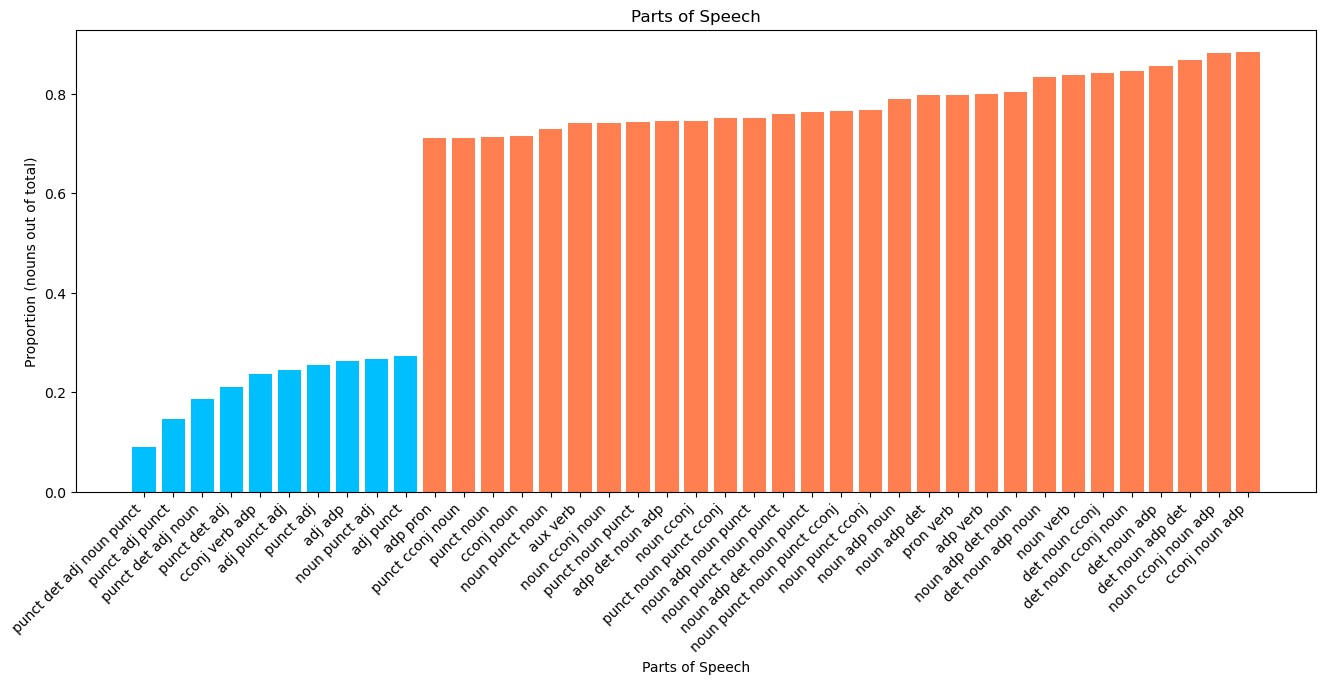

In [30]:
# Create a bar chart that reflects the most prominent POS by word class.

bar_pos(dictionary=cvec_pos['dict'], colour_range=[10,29])

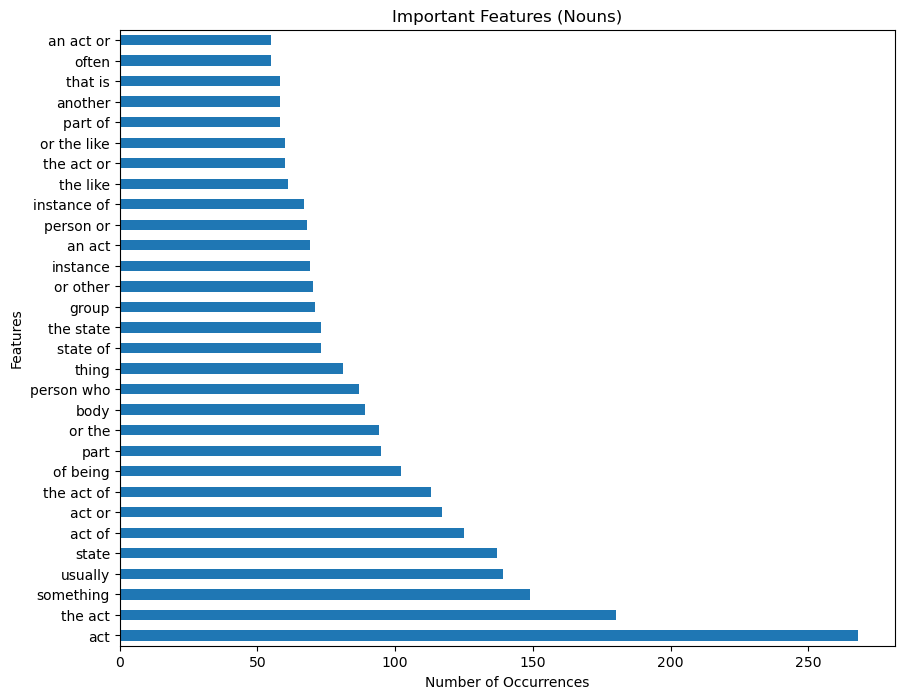

In [31]:
# Plot a bar graph showing the most prominent features for nouns.

bar_features(df=df_vectorised_nouns,
             title='Nouns')

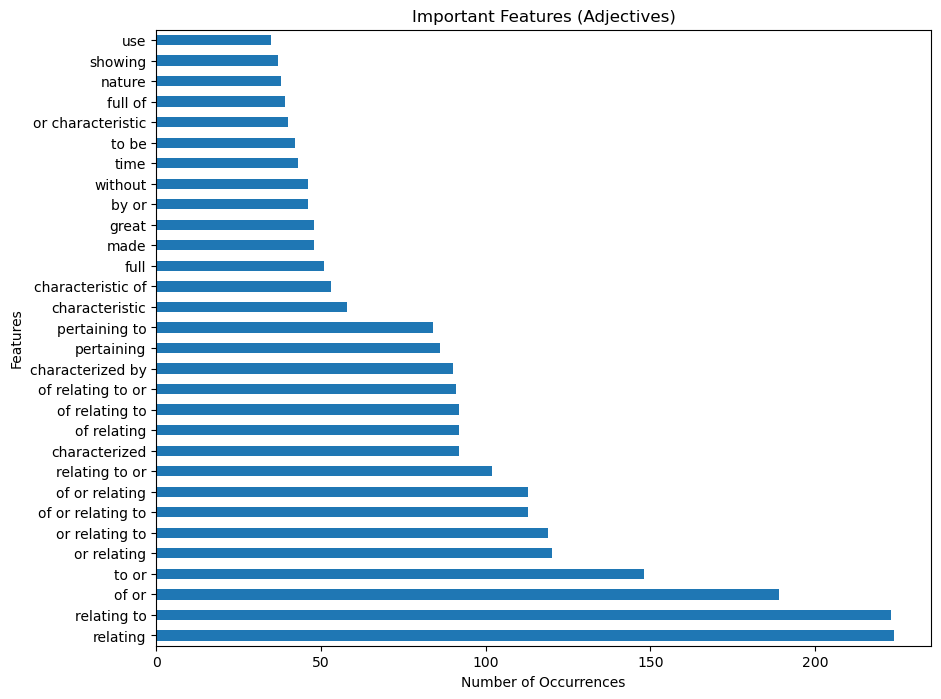

In [32]:
# Plot a bar graph showing the most prominent features for adjectives.

bar_features(df=df_vectorised_adjs,
             title='Adjectives')

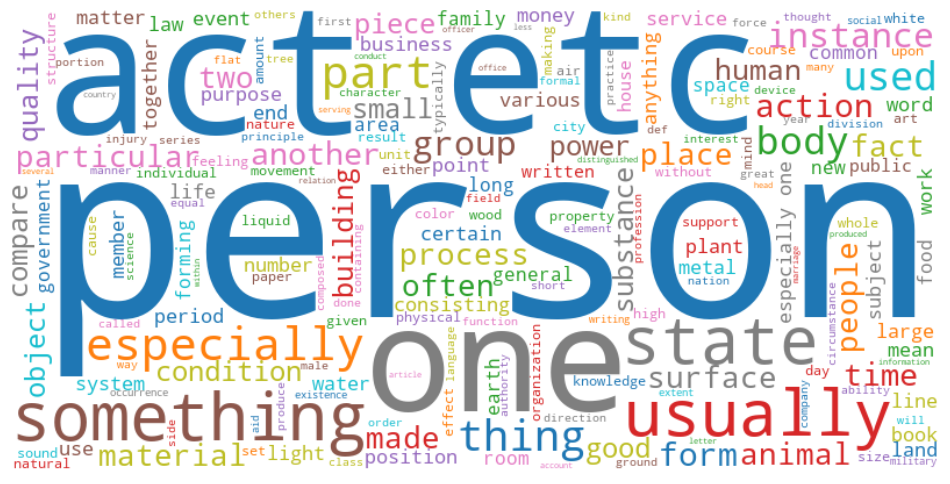

In [33]:
# Generate word cloud for definitions of nouns.

get_wordcloud(' '.join(i for i in df_words[df_words.word_class == 0].definition.values))

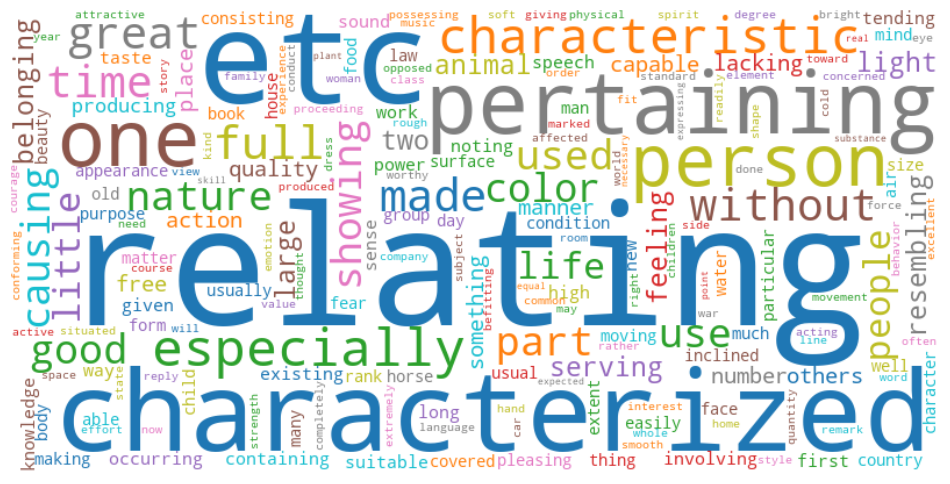

In [34]:
# Generate word cloud for definitions of adjectives.

get_wordcloud(' '.join(i for i in df_words[df_words.word_class == 1].definition.values))

### Answer

The bar chart above shows the most prominent POS combinations. The two word clouds shown are for nouns and adjectives, respectively.

It is useful to analyse them in tandem because they are related to one another. Specifically, words and phrases are examples of POS. 

It is very encouraging, though somewhat expected, to see that there are notable POS combinations. POS combinations, being groups, are general. They don’t lend actual meaning to sentences. Instead, they show _structure_. Structure is **independent** of the words themselves. Take for example the following sentences:
I am hungry
Am I hungry

Despite having the exact same words, they have completely different meanings. It’s because the order of the words is not the same, ie. their structures are different. This should illustrate how and why POS can be thought of as related to, but also different from actual words. 

The word clouds, on the other hand, show us words from definitions themselves. These are of course useful as well. Specifically, unlike POS, some of them may exist only within nouns or only within adjectives. But that is nearly impossible for POS. Therefore these phrases may still be very important predictors of word classes. Some examples include ‘act’, ‘relating’, ‘characterized’. These words, and their related phrases, appear almost exclusively in their respective word classes.

Finally, there are a lot more POS combinations highlighted for nouns rather than for adjectives. One possibility could be that definitions for nouns tend to be more structured. A consequence of this might be that definitions of nouns tend to be longer than that of adjectives, which is supported by the distribution of lengths chart above. It might mean that the model could experience more difficulty classifying adjectives. It may be possible to finetune the model to reduce this issue, if it exists, while in the long run, it may be worthwhile to consider that this may just be an inherent drawback for definitions of adjectives.

### Will multicollinearity be an issue?

In [35]:
# Obtain correlation matrix of vectorised features.

corr = df_vectorised.drop('word_class', axis=1).corr()

In [36]:
# Create a dictionary that only reflects highly-correlated features.

corr_high = {feature: [] for feature in corr.columns}

for feature in corr_high.keys():
    
    for other_feature in corr_high.keys():
        
        # 'Highly-correlated' will be defined as correlation > 0.75.
        if corr.loc[feature, other_feature] > 0.75 and feature != other_feature:
            
            corr_high[feature].append(other_feature)

# Eliminate features that are not highly correlated with any other features.
corr_high = {feature: lst for feature, lst in corr_high.items() if len(lst) > 0}

In [37]:
# View highly-correlated features in a DataFrame.

pd.DataFrame.from_dict(corr_high, orient='index')

,0,1,2,3,4,5,6,7
act,the act,None,None,None,None,None,None,None
act of,the act of,None,None,None,None,None,None,None
act or instance,act or instance of,an act,an act or,an act or instance,instance,instance of,or instance,or instance of
act or instance of,act or instance,an act,an act or,an act or instance,instance,instance of,or instance,or instance of
an act,act or instance,act or instance of,an act or,an act or instance,or instance,or instance of,None,None
an act or,act or instance,act or instance of,an act,an act or instance,instance,instance of,or instance,or instance of
an act or instance,act or instance,act or instance of,an act,an act or,instance,instance of,or instance,or instance of
characteristic,characteristic of,or characteristic,None,None,None,None,None,None
characteristic of,characteristic,or characteristic,None,None,None,None,None,None
characterized,characterized by,None,None,None,None,None,None,None


### Answer

This correlation matrix is basically a result of setting `ngram_range` to anything other than (1,1). Leaving these features as they are runs the risk of misclassification arising from overestimation of combined importance of features, which is something NB is prone to. Setting `ngram_range` as (1,1) risks losing out on certain important features. Manual selection is an option, but it may cause errors when trying to ‘brute-force’ models with varying hyperparameters.

Taking a closer look at the matrix reveals that all of the 3-word and 4-word features are merely combinations of other prominent features; for example, ‘act or instance of’ is basically a combination of ‘act or’ and ‘instance of’, both of which are also present in the matrix. 

Is there an actual case for setting `ngram_range` beyond (2,2)? Yes, it is actually to capture unique combinations where the individual words themselves may not mean much. For example, consider the idiom ‘to kill two birds with one stone’. This is a 7-word phrase. Let’s assume, that for whatever reason, this is a common idiom in the data and is specifically used in relation to 1 of the classifications. This is very valuable information! Individually, the words ‘to’, ‘kill’, ‘two’, etc. may not be important features. That’s because while all of them have individual meanings, when put together, they form a very specific meaning. 

But what this means is that this project is unlikely to benefit from it, and there is a way to mostly prove it. If we choose to go through with it and drop correlated features manually, these are the considerations we should have:
The key word (such as ‘act’, ‘relating’) must obviously not be dropped, or all other words would cease to exist as well. 
Overly-specific, yet repetitive, phrases that have their components also included in the matrix will be dropped. Example: ‘act or’ + ‘instance of’ → ‘act or instance of’
For the words that appear a lot less - for example, ‘full’ and ‘full of’, whether the combined feature will be dropped depends on the root word. For example, ‘full’ can be used in many different contexts, so it may be safer to keep both. On the other hand, ‘pertaining’ is a very specific word that is generally followed by ‘to’, and has specific use cases.
Phrases that mostly contain words that have little meaning by themselves should be retained. There aren’t many, but a good example is ‘to or’. By itself, it doesn’t mean much, but there could be numerous phrases that use it, and removing it entirely would be detrimental. In general, phrases being removed should have at least 1 word that is not a linking, ‘helper’ type of word. This ensures that only specific phrases are being removed.

According to the criteria set out above, these phrases would have been removed:
- 'the act of'
- 'act or instance'
- 'act or instance of'
- 'an act or'
- 'an act or instance'
- 'characteristic of'
- 'characterized by'
- 'consisting of'
- 'of or relating to'
- 'of or relating'
- 'of relating to'
- 'of relating to or'
- 'or characteristic'
- 'or instance of'
- 'or relating to'
- 'or relating to or'
- 'or characteristic'
- 'or relating to'
- 'or the like'
- 'person or thing'
- 'pertaining to'
- 'relating to'
- 'relating to or'
- 'state of being'
- 'the act of'
- 'the state of'
- 'the state of being'

The following words and phrases remain:
- 'act',
- 'act of',
- 'an act',
- 'characteristic',
- 'characterized',
- 'consisting',
- 'full',
- 'full of',
- 'instance',
- 'instance of',
- 'like',
- 'of relating',
- 'or instance',
- 'or relating',
- 'or the',
- 'or thing',
- 'part',
- 'part of',
- 'person or',
- 'pertaining',
- 'relating',
- 'state of',
- 'the act',
- 'the like',
- 'the state',
- 'thing',
- 'to or'

Based on the above, there’s little merit in setting `ngram_range` to anything other than (1,2). 

In [38]:
# Save amended DataFrame.

df_words.to_csv('../data/nouns_and_adjectives_and_pos.csv')